<a href="https://colab.research.google.com/github/seoulartgirl/GithubPortfolio/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D10_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%A5%BC%EC%9C%84%ED%95%9C%EB%94%A5%EB%9F%AC%EB%8B%9D2_%EC%8B%9C%ED%80%80%EC%8A%A4%EB%B0%A9%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 텍스트를 위한 딥러닝#2

In [ ]:
import numpy as np
import os, pathlib, shutil, random
from tensorflow import keras

## 시퀀스 모델 방식
- 단어를 시퀀스로 처리하기

### 1. 데이터 준비하기

#### 예제 데이터셋: IMDB 영화리뷰
- 앤드류 마스(Andrew Mass)의 스탠포드 페이지에서 다운로드

**데이터 다운로드**

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2024-06-19 06:34:05--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  51.1MB/s    in 1.6s    

2024-06-19 06:34:06 (51.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
!tar -xf aclImdb_v1.tar.gz

In [ ]:
!rm -r aclImdb/train/unsup

**데이터 준비**

In [ ]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [ ]:
import os, pathlib, random, shutil

base_dir = pathlib.Path('aclImdb') #폴더 경로 이름
train_dir = base_dir / 'train'
val_dir = base_dir / 'val'
test_dir = base_dir / 'test'

for category in ('neg', 'pos'):
    os.makedirs(val_dir / category) # 경로(디렉토리) 만들기
    files = os.listdir(train_dir / category)
    random.Random(1237).shuffle(files)
    num_val_samples = int(0.2 * len(files)) #셔플의 앞 20%를 validation 샘플로 이용
    val_files = files[-num_val_samples:] #뒤에 있는 데이터들이 val 데이터로 들어감
    for fname in val_files: #코드로 파일 옮기기
        shutil.move(train_dir / category / fname, #원본소스
                    val_dir / category / fname) #validation 디렉토리

batch_size = 32
train_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/val', batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/test', batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**정수 시퀀스 데이터셋 준비하기**

In [ ]:
from keras import Input, Model, layers

In [ ]:
max_tokens = 20000
maxlen = 600 # 최대 길이 600문자
text_vect = layers.TextVectorization(max_tokens=max_tokens,
                                     output_sequence_length=maxlen,
                                    output_mode='int')
#input, target중 input(x)만 받음
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vect.adapt(text_only_train_ds)

# num_parallel_calls=4 : 다중 CPU 코어 활용을 위한 매개변수 - 코어 수 지정
int_train_ds = train_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)
int_val_ds = val_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)
int_test_ds = test_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)

### 2. 모델 구성하고 훈련하기

#### 1) 원-핫 인코딩된 벡터 시퀀스로 시퀀스 모델 만들기

In [ ]:
import tensorflow as tf

inputs = Input(shape=(None,), dtype=tf.int64)
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded) #양방향 - layer는 LSTM 노드는 32 설정
x = layers.Dropout(0.5)(x) # 양방향이라 64개
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_1 (TFOpLambda)   (None, None, 20000)       0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                5128448   
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5128513 (19.56 MB)
Trainable params: 5128513 (19.56 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**첫 번째 시퀀스 모델 훈련하기**

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/GithubPortfolio/DeepLearning/model/'
model_name = model_path + 'aclImdb_one_hot_bidir_lstm.h5'
callbacks = [keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)]

history = model.fit(int_train_ds.cache(), #모델 찌꺼기들 저장 후 fit
                    validation_data=int_val_ds.cache(),
                    epochs=10, callbacks=callbacks)
best_model = keras.models.load_model(model_name)
print(f'정수형 임베딩 적용-테스트 정확도 : {best_model.evaluate(int_test_ds)[1]:.4f}')

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.5937 - accuracy: 0.6775

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 93s 140ms/step - loss: 0.5937 - accuracy: 0.6775 - val_loss: 0.5288 - val_accuracy: 0.7380
Epoch 2/10
625/625 [==============================] - 86s 138ms/step - loss: 0.3796 - accuracy: 0.8551 - val_loss: 0.3893 - val_accuracy: 0.8522
Epoch 3/10
625/625 [==============================] - 87s 139ms/step - loss: 0.3005 - accuracy: 0.8934 - val_loss: 0.2941 - val_accuracy: 0.8828
Epoch 4/10
625/625 [==============================] - 85s 137ms/step - loss: 0.2543 - accuracy: 0.9147 - val_loss: 0.4211 - val_accuracy: 0.8642
Epoch 5/10
625/625 [==============================] - 85s 137ms/step - loss: 0.2228 - accuracy: 0.9266 - val_loss: 0.4321 - val_accuracy: 0.8644
Epoch 6/10
625/625 [==============================] - 85s 137ms/step - loss: 0.2004 - accuracy: 0.9356 - val_loss: 0.3662 - val_accuracy: 0.8794
Epoch 7/10
625/625 [==============================] - 85s 137ms/step - loss: 0.1816 - accuracy: 0.9429 - val_loss: 0.4001 - val_accuracy: 0.8

#### 2) Embedding 층으로 단어 임베딩 학습하기

#### 케라스의 Embedding layer

**임베딩 층은 lookup table**
- 임베딩 층의 입력을 사용하기 위해 입력시퀀스의 각 단어들은 모두 정수 인코딩이 되어있어야 함
- 어떤 단어 -> 단어에 부여된 고유한 정수값 -> 임베딩 층 통과 -> 밀집벡터(dense vector)
- 임베딩 층은 입력 정수에 대해 밀집 벡터로 맵핑하고 이 밀집벡터는 인공신경망의 학습과정에서 가중치가 학습되는 것과 같은 방식으로 훈련됨
- 훈련과정에서 단어는 모델이 풀고자하는 작업에 맞는 값으로 업데이트되는데 이 밀집벡터를 **임베딩 벡터** 라고 함

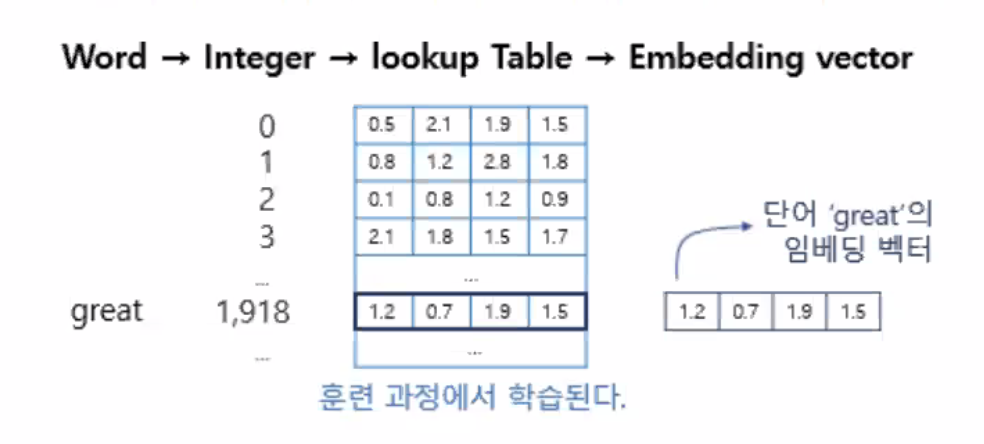

**tf.keras.layers.Embedding()**
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

```python
tf.keras.layers.Embedding(input_dim, #차원
                          output_dim, #다음 차원
                          embeddings_initializer='uniform',
                          embeddings_regularizer=None,
                          embeddings_constraint=None,
                          mask_zero=False,
                          weights=None,
                          lora_rank=None,
                          **kwargs)
- input_dim : Integer. Size of vocabulary, maximum integer index+1
- output_dim : Integer, Dimension of dense embedding
```


**`Embedding` 층 만들기**

In [ ]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

**밑바닥부터 훈련하는 `Embedding` 층을 사용한 모델**

In [ ]:
inputs = Input(shape=(None,), dtype=tf.int64)
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded) #양방향 - layer는 LSTM 노드는 32 설정
x = layers.Dropout(0.5)(x) # 양방향이라 64개
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_path = '/content/drive/MyDrive/Colab Notebooks/GithubPortfolio/DeepLearning/model/'
model_name = model_path + 'aclImdb_embedding_bidir_lstm.h5'
callbacks = [keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)]

history = model.fit(int_train_ds.cache(), #모델 찌꺼기들 저장 후 fit
                    validation_data=int_val_ds.cache(),
                    epochs=10, callbacks=callbacks)
best_model = keras.models.load_model(model_name)
print(f'임베딩 layer 적용-테스트 정확도 : {best_model.evaluate(int_test_ds)[1]:.4f}')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 47ms/step - loss: 0.3584 - accuracy: 0.8653 - val_loss: 0.3478 - val_accuracy: 0.8530
Epoch 3/10
625/625 [==============================] - 28s 45ms/step - loss: 0.2938 - accuracy: 0.8956 - val_loss: 0.3557 - val_accuracy: 0.8576
Epoch 4/10
625/625 [==============================] - 28s 45ms/step - loss: 0.2425 - accuracy: 0.9180 - val_loss: 0.3510 - val_accuracy: 0.8646
Epoch 5/10
625/625 [==============================] - 28s 45ms/step - loss: 0.2102 - accuracy: 0.9293 - val_loss: 0.3508 - val_accuracy: 0.8714
Epoch 6/10
625/625 [==============================] - 29s 46ms/step - loss: 0.1806 - accuracy: 0.9404 - val_loss: 0.4007 - val_accuracy: 0.8680
Epoch 7/10
625/625 [==============================] - 28s 45ms/step - loss: 0.1588 - accuracy: 0.9495 - val_loss: 0.7066 - val_accuracy: 0.7760
Epoch 8/10
625/625 [==============================] - 29s 46ms/step - loss: 0.1412 - accuracy: 0.9575 - val_loss: 0.4237 - val_accuracy: 0.8620
Epo

#### 패딩과 마스킹 이해하기

**마스킹을 활성화한 `Embedding` 층 사용하기**

In [ ]:
# mask_zero=True 마스킹 활성화
inputs = Input(shape=(None,), dtype=tf.int64)
embedded = layers.Embedding(input_dim=max_tokens,
                            output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded) #양방향 - layer는 LSTM 노드는 32 설정
x = layers.Dropout(0.5)(x) # 양방향이라 64개
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
# model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_path = '/content/drive/MyDrive/Colab Notebooks/GithubPortfolio/DeepLearning/model/'
model_name = model_path + 'aclImdb_embedding_bidir_lstm_with_masking.h5'
callbacks = [keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)]

history = model.fit(int_train_ds.cache(), #모델 찌꺼기들 저장 후 fit
                    validation_data=int_val_ds.cache(),
                    epochs=10, callbacks=callbacks)
best_model = keras.models.load_model(model_name)
print(f'임베딩 layer with masking 적용-테스트 정확도 : {best_model.evaluate(int_test_ds)[1]:.4f}')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

#### 3) 사전 훈련된 단어 임베딩 사용하기

In [ ]:
# glove 임베딩 모델 사용 : glove.6B
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-06-19 07:33:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-06-19 07:33:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-19 07:33:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**GloVe 단어 임베딩 파일 파싱하기**

In [ ]:
import numpy as np
path_glovefile = 'glove.6B.100d.txt'
embedding_idx ={}
with open(path_glovefile) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embedding_idx[word] = coefs

print(f'단어벡터 개수: {len(embedding_idx)}')

단어벡터 개수: 400000


**GloVe 단어 임베딩 행렬 준비하기**

In [ ]:
embed_dim = 100
vocabs = text_vect.get_vocabulary()
word_idx = dict(zip(vocabs, range(len(vocabs))))
embedding_matrix = np.zeros((max_tokens, embed_dim)) #2차원으로 해야함 - 괄호 2번

for word, i in word_idx.items():
    if i < max_tokens:
        embedding_vector = embedding_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(input_dim=max_tokens,
                                   output_dim=embed_dim,
                                  embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                   mask_zero=True,
                                   trainable=False)

**사전 훈련된 임베딩을 사용하는 모델**

In [ ]:
inputs = Input(shape=(None,), dtype=tf.int64)
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded) #양방향 - layer는 LSTM 노드는 32 설정
x = layers.Dropout(0.5)(x) # 양방향이라 64개
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_path = '/content/drive/MyDrive/Colab Notebooks/GithubPortfolio/DeepLearning/model/'
model_name = model_path + 'aclImdb_glove_bidir_lstm_with_masking.keras'
callbacks = [keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)]

history = model.fit(int_train_ds.cache(), #모델 찌꺼기들 저장 후 fit
                    validation_data=int_val_ds.cache(),
                    epochs=10, callbacks=callbacks)
best_model = keras.models.load_model(model_name)
print(f'Glove(사전훈련) with masking 적용-테스트 정확도 : {best_model.evaluate(int_test_ds)[1]:.4f}')

Epoch 1/10
625/625 [==============================] - 60s 85ms/step - loss: 0.5802 - accuracy: 0.6881 - val_loss: 0.4760 - val_accuracy: 0.7790
Epoch 2/10
625/625 [==============================] - 50s 80ms/step - loss: 0.4571 - accuracy: 0.7908 - val_loss: 0.4170 - val_accuracy: 0.8072
Epoch 3/10
625/625 [==============================] - 52s 83ms/step - loss: 0.4092 - accuracy: 0.8206 - val_loss: 0.3735 - val_accuracy: 0.8362
Epoch 4/10
625/625 [==============================] - 51s 82ms/step - loss: 0.3736 - accuracy: 0.8380 - val_loss: 0.3501 - val_accuracy: 0.8440
Epoch 5/10
625/625 [==============================] - 51s 81ms/step - loss: 0.3452 - accuracy: 0.8535 - val_loss: 0.3320 - val_accuracy: 0.8526
Epoch 6/10
625/625 [==============================] - 51s 82ms/step - loss: 0.3254 - accuracy: 0.8639 - val_loss: 0.3239 - val_accuracy: 0.8592
Epoch 7/10
625/625 [==============================] - 50s 81ms/step - loss: 0.3073 - accuracy: 0.8755 - val_loss: 0.3173 - val_accuracy:

In [ ]:
best_model = keras.models.load_model(model_name)
print(f'Glove(사전훈련) with masking 적용-테스트 정확도 : {best_model.evaluate(int_test_ds)[1]:.4f}')

782/782 [==============================] - 20s 20ms/step - loss: 0.2928 - accuracy: 0.8765
Glove(사전훈련) with masking 적용-테스트 정확도 : 0.8765


1. 정수형 임베딩 적용-테스트 정확도 : 0.8797
2. Embedding layer 적용-테스트 정확도 : 0.8410
3. Embedding layer with masking 적용-테스트 정확도 : 0.8796
4. Glove(사전훈련) with masking 적용-테스트 정확도 :  0.8765

---

- 작은 데이터셋을 다룰때는 사전 훈련된 임베딩을 사용하는 것이 도움이 됨

- 훈련 샘플 개수와 샘플 당 평균 단어 개수의 비율

- $ (샘플개수 / 평균샘플길이) > 1500 $ : -> 시퀀스 형태의 모델이 더 좋음

- $ (샘플개수 / 평균샘플길이) < 1500 $ : -> 바이그램 형태의 모델이 더 좋음